## Load Data

In [22]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)

In [23]:
# Load data
catagories_df = pd.read_csv("../data/disaster_categories.csv")
messages_df = pd.read_csv("../data/disaster_messages.csv")


for data in [catagories_df,messages_df]:
    display(data.head(3))
    print(data.shape)
    display(data.isna().sum())

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...


(26248, 2)


id            0
categories    0
dtype: int64

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct


(26248, 4)


id              0
message         0
original    16064
genre           0
dtype: int64

## Prep Data

In [24]:
# Merge datasets
df = messages_df.drop('original', axis=1).merge(catagories_df, on='id')
display(df.head(3))
print(df.shape)
display(df.isna().sum())

# Look for duplicates
df[df.duplicated()]

#drop duplicates
df.drop_duplicates(inplace=True)
display("Duplicates: {}".format(df.duplicated().sum()))
print(df.shape)

,id,message,genre,categories
0,2,Weather update - a cold front from Cuba that c...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,direct,related-1;request-0;offer-0;aid_related-0;medi...


(26386, 4)


id            0
message       0
genre         0
categories    0
dtype: int64

'Duplicates: 0'

(26216, 4)


In [25]:
### Split catagories

def split_catagories(row):
    cat_count_dict = {}
    cat_list = row.split(';')
    for cat_val in cat_list:
        cat, val = cat_val.split('-')
        cat_count_dict[cat] = val
    return cat_count_dict

df = df.drop('id', axis=1).reset_index()

categories = pd.DataFrame(list(df['categories'][:].apply(split_catagories))).reset_index()
df = df.merge(categories, on='index')
df.drop(['categories', 'index'], axis=1, inplace=True)

for col in df.columns.tolist():
    if col not in ['message', 'genre']:
        df[col] = df[col].astype('int')

## Explore Data

In [26]:
# Tidy up categories
long_df = df.melt(id_vars=['message', 'genre'], var_name='Category')

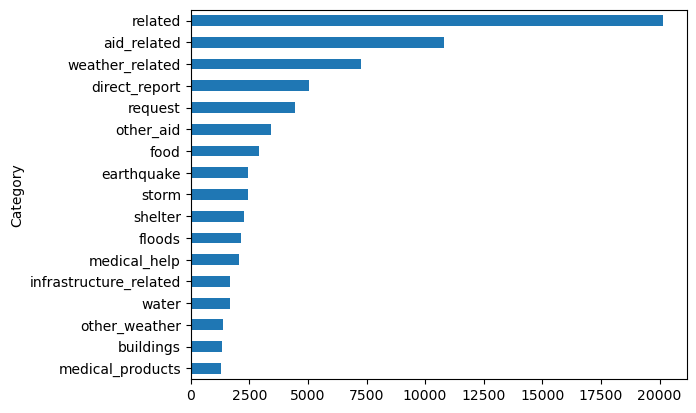

In [27]:
# Plot top 50% of categories
cat_counts = long_df.groupby('Category')['value'].sum().sort_values()[19:].plot.barh()

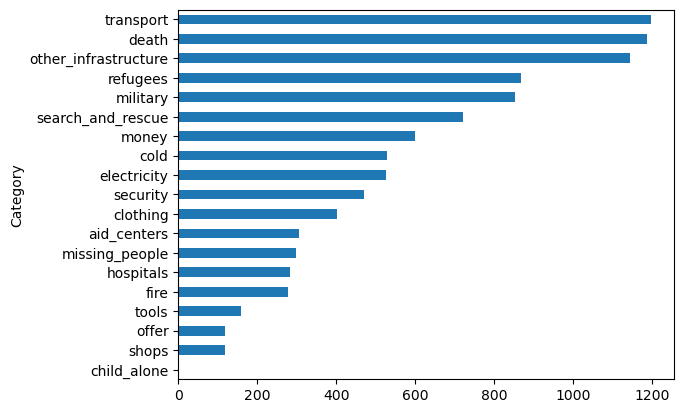

In [28]:
# Plot bottom 50% of categories
cat_counts = long_df.groupby('Category')['value'].sum().sort_values()[:19].plot.barh()

## Models

In [29]:
#Remove child alone as it has all zeros only
df.drop(['genre', 'child_alone'], axis=1, inplace=True)

In [45]:
# ML Packages
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import re

In [49]:
### Text processing
def tokenize(text):
    # Replace all urls with a urlplaceholder string
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Extract all the urls from the provided text 
    detected_urls = re.findall(url_regex, text)
    
    # Replace url with a url placeholder string
    for detected_url in detected_urls:
        text = text.replace(detected_url, url_place_holder_string)
    
    words = wordpunct_tokenize(text)
    ##TODO: Lemmatization w/ POS could improve performance ##
    stems =  [PorterStemmer().stem(w) for w in words]

    return stems

print(tokenize(df.message[0]))

['weather', 'updat', '-', 'a', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti']


In [32]:
# ML Pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier()))
    ])

In [84]:
# Split data TODO: stratified might be better
# Use sample while testing code
df_sample = df[:100]
class_names = df_sample.drop('message', axis=1).columns.values
X = df_sample.message.values
y = df_sample.drop('message', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train classifier
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# display results TODO: FIX classification breaks on large samples 
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

               related       0.83      0.90      0.86        21
               request       0.73      0.85      0.79        13
                 offer       0.00      0.00      0.00         0
           aid_related       0.76      0.87      0.81        15
          medical_help       0.00      0.00      0.00         3
      medical_products       0.00      0.00      0.00         5
     search_and_rescue       0.00      0.00      0.00         0
              security       0.00      0.00      0.00         0
              military       0.00      0.00      0.00         1
                 water       0.57      0.67      0.62         6
                  food       1.00      0.18      0.31        11
               shelter       0.00      0.00      0.00         2
              clothing       0.00      0.00      0.00         1
                 money       0.00      0.00      0.00         0
        missing_people       0.00      